In [167]:
import monai
from utils import plot_3d_image

In [168]:
def load_scan(path):
    """
    Load and preprocess a CT scan from a file path or uploaded file.

    Args:
        path (str or UploadedFile): The file path or uploaded file object of the CT scan.

    Returns:
        dict: A dictionary containing the preprocessed CT scan image tensor with key "image".
              Returns None if the input path is None.
    """
    if path is None:
        return None
    
    # Define the preprocessing transforms
    transforms = monai.transforms.Compose([
        monai.transforms.LoadImaged(keys=["image"], ensure_channel_first=True),
        monai.transforms.EnsureTyped(keys=["image"]),
        monai.transforms.Orientationd(keys=["image"], axcodes="SPL"),
        monai.transforms.Spacingd(keys=["image"], pixdim=[3,1,1], mode="bilinear"),
        monai.transforms.CropForegroundd(keys=["image"], source_key="image"),
        monai.transforms.ScaleIntensityRanged(keys="image", a_min=-1024, a_max=2048, b_min=0, b_max=1, clip=True),
        monai.transforms.Lambda(func=lambda x: x["image"].as_tensor())
    ])

    # Load and preprocess the scan
    data = {"image": path}
    image = transforms(data)
    return {"image": image}


In [169]:
image_dict = load_scan("/home/suraj/Repositories/lighter-ct-fm/semantic-search-app/assets/scans/TotalSegmentator_0006_0000.nii.gz")

2024/08/04 00:35:44.007  |  ⚠️  WARNING   |  monai.transforms.croppad.dictionary               ]8;id=547562;file:///home/suraj/miniconda3/envs/lighter_dev/lib/python3.10/site-packages/monai/utils/deprecate_utils.py\deprecate_utils.py]8;;\:]8;id=293120;file:///home/suraj/miniconda3/envs/lighter_dev/lib/python3.10/site-packages/monai/utils/deprecate_utils.py#38\38]8;;\
CropForegroundd.__init__:allow_smaller: Current default value of argument                                          
`allow_smaller=True` has been deprecated since version 1.2. It will be changed to                                  
`allow_smaller=False` in version 1.5.                                                                              

In [170]:
import torch
import os
from monai.networks.nets import SegResNetDS
from lighter.utils.model import adjust_prefix_and_load_state_dict

# Wrap the segresnet model in a module that returns the embeddings
class EmbeddingModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = adjust_prefix_and_load_state_dict(
                    ckpt_path="/mnt/data1/CT_FM/latest_fm_checkpoints/original/epoch=369-step=185000-v1.ckpt",
                    ckpt_to_model_prefix={"backbone." : "encoder"},
                    model=SegResNetDS(
                        spatial_dims=3,
                        in_channels=1,
                        out_channels=1,
                        init_filters=32,
                        blocks_down=[1, 2, 2, 4, 4],
                        dsdepth=4
                    )
            )


    def forward(self, x):
        x = self.model.encoder(x)
        x.reverse()
        x = x.pop(0)
        return x
    
def load_model():
    model = EmbeddingModel()
    model.to(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model.eval()
    return model


In [171]:
class IterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, generator):
        self.generator = generator

    def __iter__(self):
        return self.generator

In [172]:
patch_size = (24,128,128)
predictor = load_model()
image = image_dict["image"]
image = image.to("cuda").unsqueeze(0)

splitter = monai.inferers.SlidingWindowSplitter(patch_size, overlap=0.5)
dataset = IterableDataset(splitter(image))
patch_dataloader = torch.utils.data.DataLoader(dataset, batch_size=32)
concept_map = torch.zeros(1, *image.shape[2:], device=image.device)

2024/08/04 00:35:51.958  |  ℹ️  INFO      |  Encountered incompatible keys during checkpoint loading.   ]8;id=316919;file:///home/suraj/Repositories/lighter/lighter/utils/model.py\model.py]8;;\:]8;id=799282;file:///home/suraj/Repositories/lighter/lighter/utils/model.py#121\121]8;;\
If intended, ignore.                                                                                               
_IncompatibleKeys(missing_keys=['up_layers.0.upsample.deconv.weight',                                              
'up_layers.0.blocks.0.norm1.weight', 'up_layers.0.blocks.0.norm1.bias',                                            
'up_layers.0.blocks.0.norm1.running_mean', 'up_layers.0.blocks.0.norm1.running_var',                               
'up_layers.0.blocks.0.conv1.weight', 'up_layers.0.blocks.0.norm2.weight',                                          
'up_layers.0.blocks.0.norm2.bias', 'up_layers.0.blocks.0.norm2.running_mean',                                      
'up_layers.0.blocks.0.norm2.running_var', 'up_layers.0.blocks.0.conv2.weight',                                     
'up_layers.0.head.weight', 'up_layers.0.head.bias', 'up_layers.1.upsample.deconv.weight',                          
'up_layers.1.blocks.0.norm1.weight', 'up_layers.1.blocks.0.norm1.bias',                                            
'up_layers.1.blocks.0.norm1.running_mean', 'up_layers.1.blocks.0.norm1.running_var',                               
'up_layers.1.blocks.0.conv1.weight', 'up_layers.1.blocks.0.norm2.weight',                                          
'up_layers.1.blocks.0.norm2.bias', 'up_layers.1.blocks.0.norm2.running_mean',                                      
'up_layers.1.blocks.0.norm2.running_var', 'up_layers.1.blocks.0.conv2.weight',                                     
'up_layers.1.head.weight', 'up_layers.1.head.bias', 'up_layers.2.upsample.deconv.weight',                          
'up_layers.2.blocks.0.norm1.weight', 'up_layers.2.blocks.0.norm1.bias',                                            
'up_layers.2.blocks.0.norm1.running_mean', 'up_layers.2.blocks.0.norm1.running_var',                               
'up_layers.2.blocks.0.conv1.weight', 'up_layers.2.blocks.0.norm2.weight',                                          
'up_layers.2.blocks.0.norm2.bias', 'up_layers.2.blocks.0.norm2.running_mean',                                      
'up_layers.2.blocks.0.norm2.running_var', 'up_layers.2.blocks.0.conv2.weight',                                     
'up_layers.2.head.weight', 'up_layers.2.head.bias', 'up_layers.3.upsample.deconv.weight',                          
'up_layers.3.blocks.0.norm1.weight', 'up_layers.3.blocks.0.norm1.bias',                                            
'up_layers.3.blocks.0.norm1.running_mean', 'up_layers.3.blocks.0.norm1.running_var',                               
'up_layers.3.blocks.0.conv1.weight', 'up_layers.3.blocks.0.norm2.weight',                                          
'up_layers.3.blocks.0.norm2.bias', 'up_layers.3.blocks.0.norm2.running_mean',                                      
'up_layers.3.blocks.0.norm2.running_var', 'up_layers.3.blocks.0.conv2.weight',                                     
'up_layers.3.head.weight', 'up_layers.3.head.bias'], unexpected_keys=[])                                           

In [173]:
features_dict = []

with torch.no_grad():
    for patches, locations in patch_dataloader:
        preds = predictor(patches.squeeze(dim=1))
        for z, y, x, pred in zip(locations[0], locations[1], locations[2], preds):
            features_dict.append(
                {
                    "features": pred,
                    "location": (z, y, x)
            })


In [174]:
all_features = torch.cat([f["features"] for f in features_dict], dim=0).reshape(-1, 512)
feature_dict_shapes = torch.cat([f["features"].unsqueeze(0) for f in features_dict], dim=0).shape

In [175]:
all_features

tensor([[ 20.6899,  22.0306,  23.0085,  ...,   3.2857,   5.6032,   1.3678],
        [  4.9285,   4.7151,   8.6629,  ..., -42.3040, -41.6242, -33.6873],
        [ 24.4980,  45.2958,  42.4528,  ..., -34.8153, -26.7461,   3.0621],
        ...,
        [ 35.4365,  21.1442,  21.7282,  ...,  10.1635,  14.2663,  30.1413],
        [  4.1366,   7.5348,   5.2757,  ..., -17.5650, -20.2090,  -4.8152],
        [-14.0002, -19.7437, -17.2421,  ...,  -2.7442,  -9.2386,   7.2229]],
       device='cuda:0')

In [176]:
all_features.shape, feature_dict_shapes

(torch.Size([23040, 512]), torch.Size([180, 512, 2, 8, 8]))

In [177]:
all_features = torch.nn.functional.normalize(all_features, p=1, dim=0)
all_features.shape

torch.Size([23040, 512])

In [178]:
all_features

tensor([[ 4.4899e-05,  4.7076e-05,  4.8309e-05,  ...,  6.3591e-06,
          1.1810e-05,  2.9123e-06],
        [ 1.0695e-05,  1.0075e-05,  1.8189e-05,  ..., -8.1874e-05,
         -8.7735e-05, -7.1729e-05],
        [ 5.3163e-05,  9.6789e-05,  8.9134e-05,  ..., -6.7381e-05,
         -5.6375e-05,  6.5201e-06],
        ...,
        [ 7.6900e-05,  4.5182e-05,  4.5621e-05,  ...,  1.9670e-05,
          3.0070e-05,  6.4179e-05],
        [ 8.9767e-06,  1.6101e-05,  1.1077e-05,  ..., -3.3995e-05,
         -4.2596e-05, -1.0253e-05],
        [-3.0382e-05, -4.2189e-05, -3.6202e-05,  ..., -5.3111e-06,
         -1.9473e-05,  1.5380e-05]], device='cuda:0')

In [179]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Perform PCA reduction on the features
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(all_features.cpu().numpy())




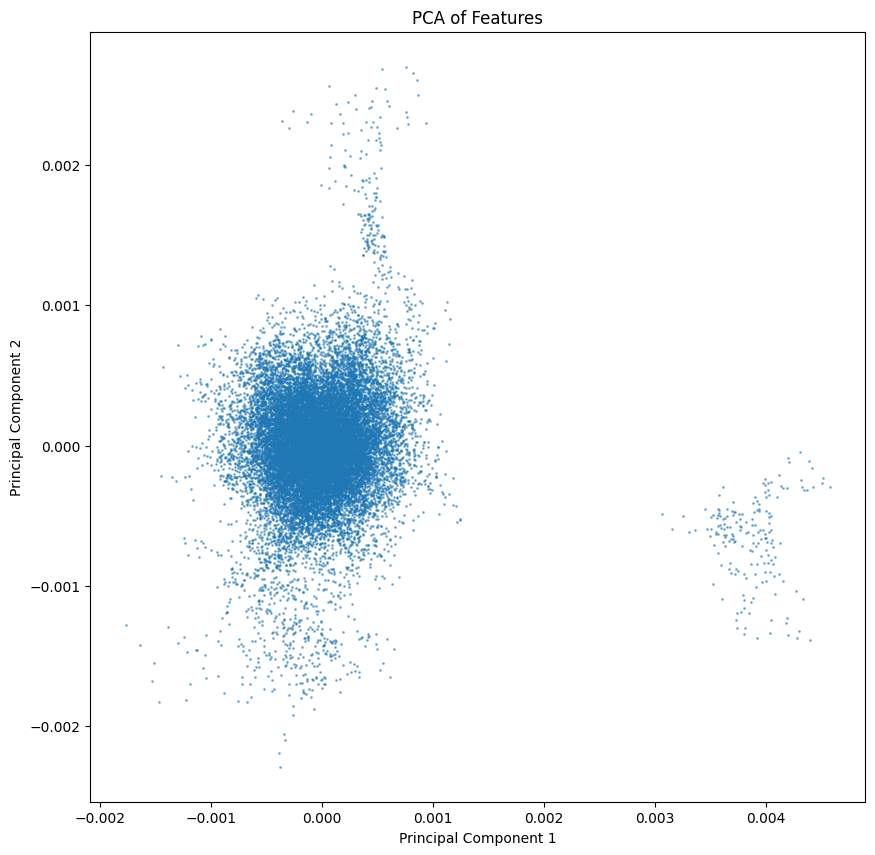

In [180]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], s=1, alpha=0.5)
plt.title('PCA of Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [181]:
# Perform KMeans clustering on the reduced features
kmeans_model = KMeans(n_clusters=120, random_state=42)
predicted_clusters = kmeans_model.fit_predict(reduced_features)

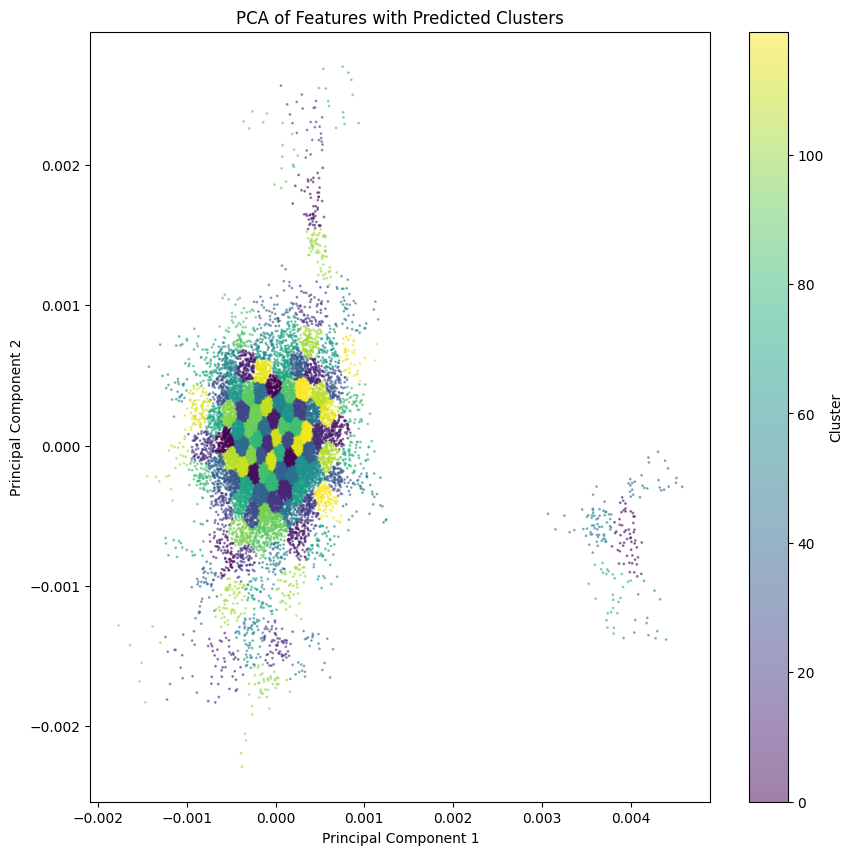

In [182]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=predicted_clusters, s=1, alpha=0.5, cmap='viridis')
plt.title('PCA of Features with Predicted Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [183]:
reshape = predicted_clusters.reshape(feature_dict_shapes[0],feature_dict_shapes[2], feature_dict_shapes[3], feature_dict_shapes[4])

In [184]:
feature_clusters = torch.tensor(predicted_clusters).view(feature_dict_shapes[0], feature_dict_shapes[2], feature_dict_shapes[3], feature_dict_shapes[4])

In [185]:
for f, cluster in zip(features_dict, feature_clusters):
    print(cluster)
    f["cluster"] = cluster

tensor([[[ 83,  37, 110,  88,  52,  63, 108,   4],
         [110,  85,  79,  94,  35,  98,  71,   2],
         [102,  93,  61,  66,  46, 111,  37,  38],
         [ 64,  41,  97,  92,  66, 110, 106,  73],
         [ 10, 106,  97,  26,  97,  13,  76,  71],
         [ 93,  63, 114, 111,  31,  49,   4,  97],
         [ 84,   2,  45,  94, 102,  92,  69,  31],
         [109,   7,  76,  49,  39,  33,  31,  14]],

        [[ 41,  23,  66,  48,  36,  85,  86,  78],
         [ 81,  97,  40,  37,  93,  84,  74,  86],
         [ 15,  99,  92,  34,  36,  29,  65,  29],
         [ 34,  69,  35,  59,  83,  82,  68,  37],
         [ 47,  70,  26, 105,  43,  66,  22,  86],
         [ 14, 111, 113,  44,  87,   2,  66,  81],
         [ 31,  78,  69,  43,   3,  33,  91, 108],
         [ 83,  15,  39,  47, 110,  19,  79, 110]]], dtype=torch.int32)
tensor([[[ 92,  79,  89,  88,  38, 106,  89,  15],
         [ 15,  58,  15,  69,  35,  63, 119,  45],
         [ 17,  76,  86,  76,  53,  86,  94,  38],
        

In [186]:
len(features_dict)

180

In [187]:
predicted_clusters

array([ 83,  37, 110, ...,  74,  37,  61], dtype=int32)

In [206]:
for item in features_dict:
    z, y, x = item["location"]
    cluster = item["cluster"]
    target_shape = concept_map[0, z.item(): (z.item() + patch_size[0]), y.item(): (y.item() + patch_size[1]), x.item(): (x.item() + patch_size[2])].shape
    interpolated_cluster = torch.nn.functional.interpolate(cluster.unsqueeze(0).unsqueeze(0).float(), size=target_shape, mode='nearest')
    concept_map[0, z.item(): (z.item() + patch_size[0]), y.item(): (y.item() + patch_size[1]), x.item(): (x.item() + patch_size[2])] = interpolated_cluster.squeeze(0).squeeze(0)
    print(f"Target shape: {target_shape}, Original cluster shape: {cluster.shape}, Interpolated shape: {interpolated_cluster.shape}")

Target shape: torch.Size([24, 128, 128]), Original cluster shape: torch.Size([2, 8, 8]), Interpolated shape: torch.Size([1, 1, 24, 128, 128])
Target shape: torch.Size([24, 128, 128]), Original cluster shape: torch.Size([2, 8, 8]), Interpolated shape: torch.Size([1, 1, 24, 128, 128])
Target shape: torch.Size([24, 128, 128]), Original cluster shape: torch.Size([2, 8, 8]), Interpolated shape: torch.Size([1, 1, 24, 128, 128])
Target shape: torch.Size([24, 128, 128]), Original cluster shape: torch.Size([2, 8, 8]), Interpolated shape: torch.Size([1, 1, 24, 128, 128])
Target shape: torch.Size([24, 128, 68]), Original cluster shape: torch.Size([2, 8, 8]), Interpolated shape: torch.Size([1, 1, 24, 128, 68])
Target shape: torch.Size([24, 128, 128]), Original cluster shape: torch.Size([2, 8, 8]), Interpolated shape: torch.Size([1, 1, 24, 128, 128])
Target shape: torch.Size([24, 128, 128]), Original cluster shape: torch.Size([2, 8, 8]), Interpolated shape: torch.Size([1, 1, 24, 128, 128])
Target s

In [207]:
import numpy as np
np.unique(predicted_clusters, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119], dtype=int32),
 array([216, 206, 416,  54, 321,  54,  84, 133, 130, 394, 182,  42, 342,
        146, 244, 479,  61,  69, 123,  84, 318, 174, 100, 272, 297,  27,
        362, 249,  15, 107, 124, 422, 106, 225, 350, 209,  53, 466, 389,
        144,  43, 333,  27, 488, 297, 334, 207, 206,  27,  41,  38,  59,
         64, 

In [208]:
np.unique(concept_map.cpu().numpy(), return_counts=True)

(array([  0.   ,   1.   ,   1.5  ,   2.   ,   3.   ,   4.   ,   4.5  ,
          5.   ,   6.   ,   6.5  ,   7.   ,   7.5  ,   8.   ,   8.5  ,
          9.   ,   9.5  ,  10.   ,  10.5  ,  11.   ,  11.5  ,  12.   ,
         12.5  ,  13.   ,  13.5  ,  14.   ,  14.5  ,  15.   ,  15.5  ,
         16.   ,  16.5  ,  17.   ,  17.5  ,  18.   ,  18.5  ,  19.   ,
         19.25 ,  19.5  ,  20.   ,  20.5  ,  21.   ,  21.25 ,  21.5  ,
         22.   ,  22.25 ,  22.5  ,  23.   ,  23.25 ,  23.5  ,  24.   ,
         24.5  ,  25.   ,  25.5  ,  26.   ,  26.5  ,  26.75 ,  27.   ,
         27.25 ,  27.5  ,  28.   ,  28.5  ,  28.75 ,  29.   ,  29.5  ,
         29.75 ,  30.   ,  30.5  ,  31.   ,  31.5  ,  31.75 ,  32.   ,
         32.5  ,  32.75 ,  33.   ,  33.5  ,  34.   ,  34.25 ,  34.5  ,
         34.75 ,  35.   ,  35.5  ,  35.75 ,  36.   ,  36.25 ,  36.5  ,
         37.   ,  37.25 ,  37.5  ,  37.625,  37.75 ,  38.   ,  38.25 ,
         38.5  ,  38.75 ,  39.   ,  39.5  ,  39.75 ,  40.   ,  40.25 ,
      

In [209]:
image_dict["image"].shape

torch.Size([1, 109, 315, 324])

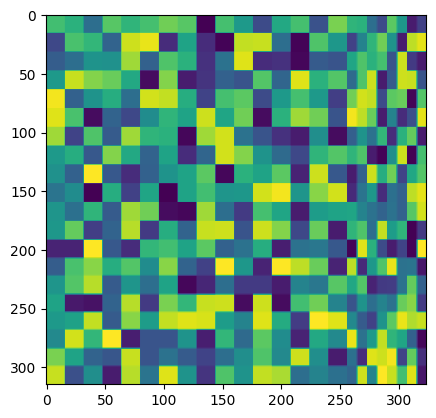

In [210]:
import matplotlib.pyplot as plt
plt.imshow(concept_map.cpu()[0, 15])

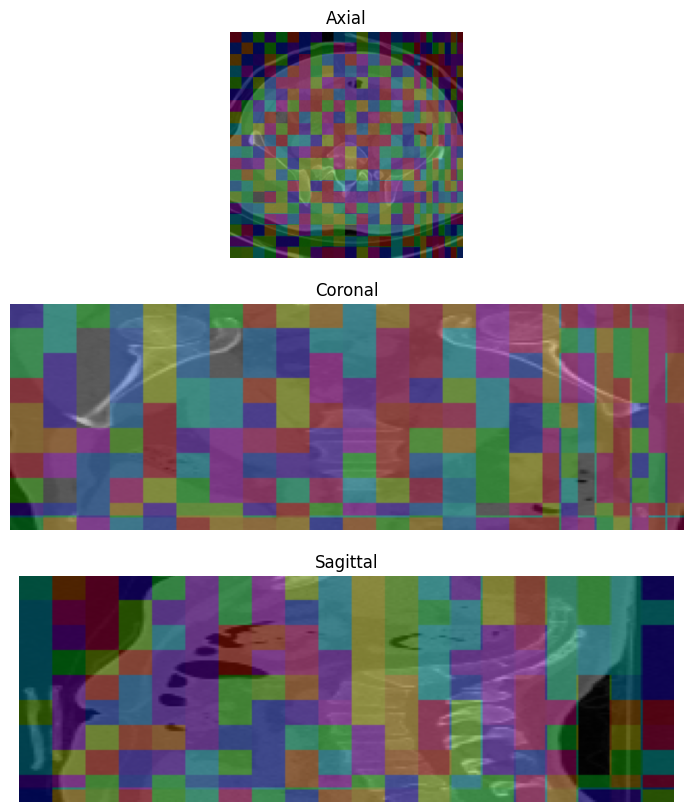

In [211]:
from monai.visualize import blend_images

image = image_dict["image"].cpu()
concept_map = concept_map.cpu()

blended_image = blend_images(image, concept_map, alpha=0.3)

plot_3d_image(blended_image)

In [84]:
concept_map.shape

torch.Size([1, 109, 315, 324])